In [28]:
import numpy as np
import json
from pathlib import Path
import open3d as o3d
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm


In [29]:
data_path = Path(r"data/depth_frames.json")

with open(data_path, "r") as f:
    data = f.read()
    data = data.replace('"timestamp"', ',"timestamp"')

with open(r"data/depth_frames_new.json", "w") as f:
    f.write(data)

In [30]:
data_path = Path(r"data/depth_frames_new.json")

with open(data_path, "r") as f:
    data = json.load(f)


len(data)

104

In [31]:
list(data[0].keys())
for k, v in data[0].items():
    if k == "depth":
        print(f"depth: {len(v)}x{len(v[0])}")
    elif k == "distortion_lookup":
        print(f"distortion_lookup: {len(v)} items")

    else:
        print(f"{k}: {v}")

depth: 360x640
focal_length: [543.6634, 543.6634]
center: [318.6215, 179.09174]
skew: 0.0
distortion_center: [1688.6938, 949.18616]
distortion_lookup: 42 items
timestamp: 724296975.353256


In [32]:
class DepthImage:

    def __init__(self, depth, focal_length, center, skew, distortion_lookup, distortion_center, timestamp):
        self.depth = np.array(depth)
        self.focal_length = focal_length
        self.center = center[::-1]
        self.skew = skew
        self.distortion_lookup = distortion_lookup
        self.distortion_center = np.array(distortion_center[::-1])/5.3
        self.intrinsic = np.array([
            [focal_length[0], skew, center[0]],
            [0, focal_length[1], center[1]],
            [0,0,1]
        ])

        x = np.arange(self.depth.shape[0])
        y = np.arange(self.depth.shape[1])
        xx, yy = np.meshgrid(x, y)
        coord_mask = np.column_stack((xx.ravel(), yy.ravel()))
        undistorted_points = np.column_stack((xx.ravel(), yy.ravel(), np.ones_like(xx.ravel()))).astype(float)

        radii = np.sqrt((undistorted_points[:,0] - self.distortion_center[0])**2 + (undistorted_points[:, 1] - self.distortion_center[1])**2)
        max_radius = np.max(radii)
        radii /= max_radius
        idxs = radii*(len(self.distortion_lookup) - 1)

        scales = np.vectorize(lambda x: self.distortion_lookup[int(np.floor(x))]*(1- (x % 1)) + self.distortion_lookup[int(np.ceil(x))]*(x%1))(idxs).reshape((len(idxs), 1))

        undistorted_points[:,:2] = (coord_mask[:,:2] - distortion_center)*(1 + scales) + distortion_center

        depth_vector = np.apply_along_axis(lambda x: self.depth[x[0], x[1]], 1, coord_mask)

        self.points = (np.linalg.inv(self.intrinsic)@undistorted_points[:,:,None]).squeeze()*depth_vector[:,None]
        self.frame = np.zeros((self.depth.shape[0], self.depth.shape[1], 3))
        self.scales = np.zeros((self.depth.shape[0], self.depth.shape[1]))
        
        for i, x in enumerate(coord_mask):
            self.frame[x[0], x[1]] = self.points[i]
            self.scales[x[0], x[1]] = scales[i][0]
            


# depth_images = [DepthImage(**x) for x in data[:1]]

In [35]:
depth_images = [DepthImage(**x) for x in tqdm(data)]
# distorted_depth_images = [DepthImage(x["depth"], x["focal_length"], x["center"], x["skew"], [0.0,0.0,0.0], x["distortion_center"], x["timestamp"]) for x in tqdm(data)]
# frames = [x.to_frame() for x in depth_images]


  0%|          | 0/104 [00:00<?, ?it/s]

100%|██████████| 104/104 [00:55<00:00,  1.88it/s]


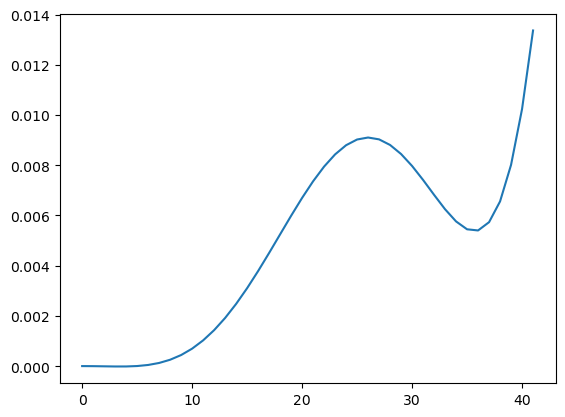

In [36]:
plt.plot(depth_images[0].distortion_lookup)

<Axes: >

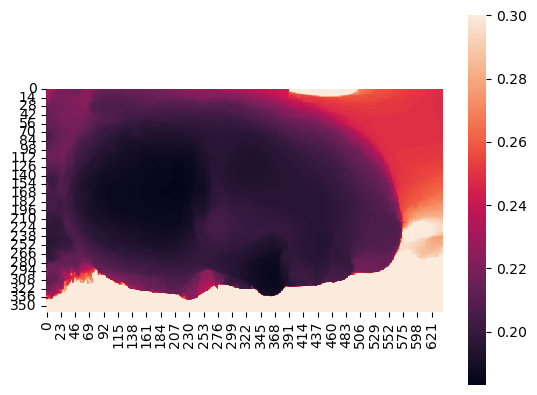

In [37]:
sns.heatmap(depth_images[10].depth, square=True, vmax=0.3)

(array([179.0917283, 318.6214717]), [179.09174, 318.6215])

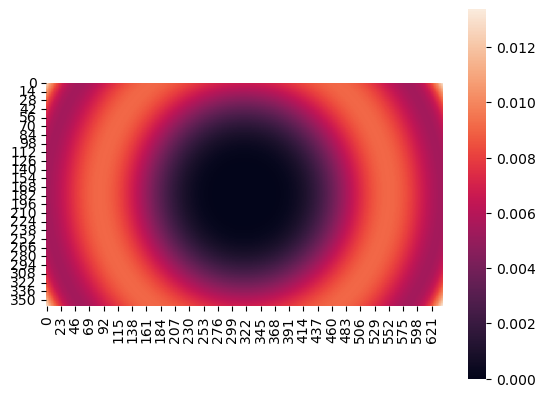

In [40]:
sns.heatmap(depth_images[10].scales, square=True)
depth_images[10].distortion_center, depth_images[10].center

In [14]:
for d in depth_images[::20]:
    pc = o3d.geometry.PointCloud()
    pc.points = o3d.utility.Vector3dVector(d.points[d.points[:,2] < 0.3])
    # o3d.visualization.draw_geometries([pc])

## Estimate normals

In [18]:
# def estimate_normals(frame: np.ndarray, valid: np.ndarray, size=3, angle=55):
#     angular_threshold = np.cos(np.deg2rad(angle))
#     normals = np.zeros_like(frame)
#     for i, row in enumerate(frame):
#         for j, val in enumerate(row):
#             if i < size or i >= len(frame) - size or j < size or j >= len(row) - size or val[2] > 0.25 or val[2] < 0:
#                 valid[i, j] = False
            
#             if valid[i][j]:
#                 dx = frame[i + size, j] - frame[i - size, j]
#                 dy = frame[i, j + size] - frame[i, j - size]

#                 normal = np.cross(dx, dy)
#                 normal = normal / np.linalg.norm(normal)
#                 normals[i, j] = normal

#                 cam_vec = frame[i, j] / np.linalg.norm(frame[i, j])

#                 if np.dot(cam_vec, normal) < angular_threshold:
#                     valid[i][j] = 0
#             else:
#                 normals[i,j] = np.array([0,0,1])

#     return normals, valid

# normals = []
# valids = []

# for d in tqdm(depth_images):
#     frame_norms, frame_valid = estimate_normals(d.frame, np.ones((d.frame.shape[0], d.frame.shape[1]), bool), angle=75, size=5)
#     normals.append(frame_norms)
#     valids.append(frame_valid)

# distorted_normals = []
# distorted_valids = []

# for d in tqdm(distorted_depth_images):
#     frame_norms, frame_valid = estimate_normals(d.frame, np.ones((d.frame.shape[0], d.frame.shape[1]), bool), angle=75, size=5)
#     distorted_normals.append(frame_norms)
#     distorted_valids.append(frame_valid)



In [19]:
# for i in range(0, len(frames), 5):

i = 60

frame = depth_images[i].frame.reshape(depth_images[i].points.shape)
# valid = valids[i].flatten()
# normal = normals[i].reshape(frame.shape)

accepted_pc = o3d.geometry.PointCloud()
accepted_pc.points = o3d.utility.Vector3dVector(frame[frame[:,2] < 0.25])
accepted_pc.estimate_normals()
# accepted_pc.normals = o3d.utility.Vector3dVector(normal[frame[:,2] < 0.25])
accepted_pc.paint_uniform_color([1, 0.706, 0])

distorted_frame = distorted_depth_images[i].frame.reshape(distorted_depth_images[i].points.shape)
# distorted_valid = distorted_valids[i].flatten()
# distorted_normal = distorted_normals[i].reshape(frame.shape)

distorted_pc = o3d.geometry.PointCloud()
distorted_pc.points = o3d.utility.Vector3dVector(distorted_frame[distorted_frame[:,2] < 0.25])
distorted_pc.estimate_normals()
# distorted_pc.normals = o3d.utility.Vector3dVector(distorted_normal[distorted_frame[:,2] < 0.25])
distorted_pc.paint_uniform_color([0.929, 0.2, 0.2])

o3d.visualization.draw_geometries([accepted_pc, distorted_pc])
# o3d.visualization.draw_geometries([accepted_pc, rejected_pc])


[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [21]:
dep = depth_images[i].points[depth_images[i].points[:,2] < 0.25]
np.max(dep[:,0]),np.max(dep[:,1]),np.max(dep[:,2]),np.min(dep[:,0]),np.min(dep[:,1]),np.min(dep[:,2])

(0.01804513432726813,
 0.19563854115192406,
 0.24975586,
 -0.15184710508444996,
 -0.08466429820871504,
 0.16753924)